In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load and prepare the data
file_path = 'IBM_2006-01-01_to_2018-01-01.csv'
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data.drop('Name', axis=1)


In [2]:
# Identify missing days 
all_days = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')

missing_days = all_days.difference(data.index)

missing_days_df = pd.DataFrame(missing_days, columns=['MissingDate'])
missing_days_df['DayOfWeek'] = missing_days_df['MissingDate'].dt.day_name()

print("Missing days with day of the week:")
print(missing_days_df)

pattern_analysis = missing_days_df['DayOfWeek'].value_counts()
print("\nPattern of missing days by day of the week:")
print(pattern_analysis)

Missing days with day of the week:
     MissingDate DayOfWeek
0     2006-01-07  Saturday
1     2006-01-08    Sunday
2     2006-01-14  Saturday
3     2006-01-15    Sunday
4     2006-01-16    Monday
...          ...       ...
1354  2017-12-16  Saturday
1355  2017-12-17    Sunday
1356  2017-12-23  Saturday
1357  2017-12-24    Sunday
1358  2017-12-25    Monday

[1359 rows x 2 columns]

Pattern of missing days by day of the week:
DayOfWeek
Saturday     625
Sunday       625
Monday        59
Friday        21
Thursday      17
Tuesday        8
Wednesday      4
Name: count, dtype: int64


In [3]:
# NaN values
data[data.isna().any(axis=1)]

,Open,High,Low,Close,Volume
Date,,,,,
2017-07-31,NaN,144.93,NaN,144.67,4355718


In [4]:
# cleanup
data_resampled = data.asfreq('D')
data_resampled = data_resampled.interpolate(method='time')

In [5]:
# Use only the 'Close' column for this example
close_prices = data_resampled['Close'].values.reshape(-1, 1)

# Scalers

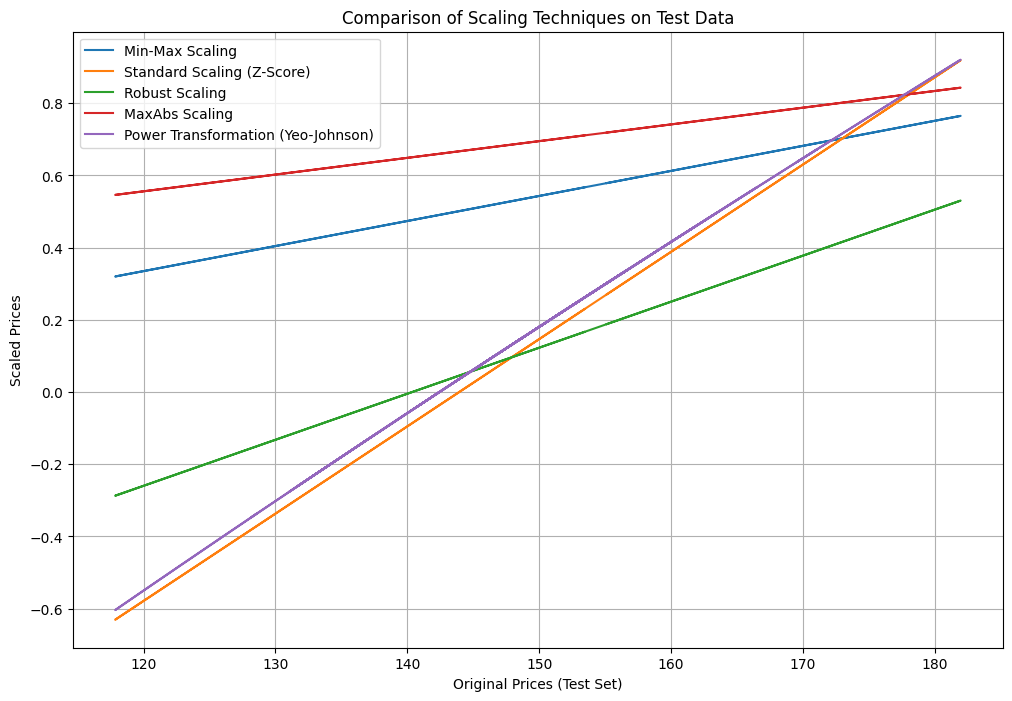

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler, QuantileTransformer, PowerTransformer

# Assume `close_prices` is your input array of stock prices
close_prices = np.array(close_prices).reshape(-1, 1)

# Split the data into train and test sets
train_size = int(len(close_prices) * 0.8)
train_set, test_set = close_prices[:train_size], close_prices[train_size:]

# Dictionary to store scalers and their results
scalers = {
    "Min-Max Scaling": MinMaxScaler(),
    "Standard Scaling (Z-Score)": StandardScaler(),
    "Robust Scaling": RobustScaler(),
    "MaxAbs Scaling": MaxAbsScaler(),
    "Power Transformation (Yeo-Johnson)": PowerTransformer(method="yeo-johnson"),
}

# Create a DataFrame to store test set results after scaling
comparison_df = pd.DataFrame({"Original (Test Set)": test_set.flatten()})

# Fit each scaler on the training set and transform the test set
for scaler_name, scaler in scalers.items():
    scaler.fit(train_set)  # Fit on training set only
    scaled_test_set = scaler.transform(test_set)  # Transform test set
    comparison_df[scaler_name] = scaled_test_set.flatten()

# Plot the scaled results for comparison
plt.figure(figsize=(12, 8))
for column in comparison_df.columns[1:]:
    plt.plot(comparison_df["Original (Test Set)"], comparison_df[column], label=column)

plt.title("Comparison of Scaling Techniques on Test Data")
plt.xlabel("Original Prices (Test Set)")
plt.ylabel("Scaled Prices")
plt.legend()
plt.grid(True)
plt.show()


# LSTM

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [23]:
# Create the dataset
def create_dataset(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [39]:
# Split the dataset
train_size = int(len(close_prices) * 0.8)  # 80% training, 20% testing
train_set, test_set = close_prices[:train_size], close_prices[train_size:]

# Initialize and fit the scaler on the training set
scaler = RobustScaler()
scaler.fit(train_set)  # Fit only on training data

# Transform both train and test sets
train_scaled = scaler.transform(train_set)
test_scaled = scaler.transform(test_set)

In [40]:
time_steps = 60  # Use the past 60 days for predictions

X_train, y_train = create_dataset(train_scaled, time_steps)
X_test, y_test = create_dataset(test_scaled, time_steps)

In [41]:

# Step 4: Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

/Users/z139209/Documents/ADAML/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [55]:
# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test))


Epoch 1/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.9258e-04 - val_loss: 3.1079e-04
Epoch 2/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 4.2662e-04 - val_loss: 3.1105e-04
Epoch 3/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 3.8097e-04 - val_loss: 3.7393e-04
Epoch 4/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.0216e-04 - val_loss: 3.0641e-04
Epoch 5/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.4997e-04 - val_loss: 3.2830e-04


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


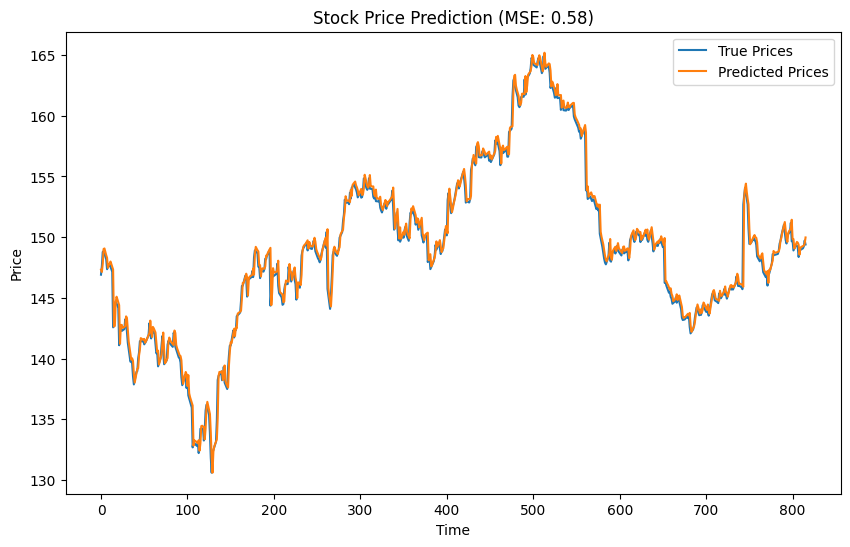

In [56]:
# Predictions and Rescaling
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Original prices for comparison
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MSE
error = mean_squared_error(y_test_rescaled, predictions)

plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='True Prices')
plt.plot(predictions, label='Predicted Prices')
plt.title(f"Stock Price Prediction (MSE: {error:.2f})")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
